# Random Forest Regression

In this notebook, I take the raw water structure data and perform Random Forest regression using hydration free energies, $\mu_{\nu}$, as labels.

## IMPORT MODULES

In [1]:
## MAKE MATPLOTLIB INLINE
%matplotlib inline

## IMPORT OS
import os

## IMPORT RANDOM
import random

## IMPORT NUMPY
import numpy as np  # Used to do math functions

## IMPORT PANDAS
import pandas as pd

## IMPORT LASSO K-FOLD
from sam_analysis.ml_tools.random_forest_regression import RandomForestRegression

## IMPORT GLOBAL INPUTS
from sam_analysis.ml_tools.globals import NH2_GROUPS, CONH2_GROUPS, OH_GROUPS

## FUNCTION TO SAVE AND LOAD PICKLE FILES
from sam_analysis.core.pickles import load_pkl

## IMPORT CHECK SERVER PATH
from sam_analysis.core.check_tools import check_server_path

## IMPORT PLOTTING TOOLS
from sam_analysis.plotting.plots import plot_parity, plot_bar, plot_line

## SET PATHS AND LOAD DATA
NOTE: "raw_regression_data.pkl" was converted into a pd.dataframe post analysis. Will need to change output of analysis to the data frame to facitate analysis and reproducibility.

In [2]:
## WORKING DIRECTORY
project_dir = r"/home/bdallin/python_projects/sam_analysis/sam_analysis"
data_dir    = "raw_data"

## DATA FILE
data_pkl = r"rescaled_uncorrelated_regression_data.pkl"

## FIGURE PATHS
manuscript_dir = r"/mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams"
figure_dir     = r"figures"

## LOAD DATA
path_data_pkl = os.path.join( project_dir, data_dir, data_pkl )
raw_data      = load_pkl( path_data_pkl )

LOADING PKL FILE...
LOADED PKL FROM /home/bdallin/python_projects/sam_analysis/sam_analysis/raw_data/rescaled_uncorrelated_regression_data.pkl



## TRAIN RANDOM FOREST REGRESSION

In [3]:
## OPTIMAL HYPERPARAMETERS
n_trees      = 200    # number of trees (splits)
max_samples  = None   # max samples for bootstraping (bagging)
max_features = 0.5    # max fract. of features at each split
max_depth    = None   # max tree depth
n_features   = 5      # number features

## INITIALIZE RANDOM FOREST
rf_obj = RandomForestRegression( n_trees      = n_trees,
                                 max_samples  = max_samples,
                                 max_features = max_features,
                                 max_depth    = max_depth,
                                 n_features   = n_features )

## COMPUTE RANDOM FOREST
rf_obj.compute( raw_data )

## UPDATE COLOR LIST
colors = []
for gg in range(len(raw_data["sample1"].index.values)):
    if gg in NH2_GROUPS and gg != 0:
        colors.append( "slateblue" )
    if gg in CONH2_GROUPS and gg != 0:
        colors.append( "darkseagreen" )
    if gg in OH_GROUPS and gg != 0:
        colors.append( "tomato" )
    if gg == 0:
        colors.append( "darkgrey" )
        
## STORE RESULTS
y_indus        = rf_obj.y_indus
y_indus_err    = rf_obj.y_indus_err
y_pred         = rf_obj.y_pred
y_pred_err     = rf_obj.y_pred_err
rmse           = rf_obj.rmse
rmse_err       = rf_obj.rmse_err
weights_df     = rf_obj.weights
weights_err_df = rf_obj.weights_err

## PLOTTING PARITY


--- CREATING PARITY PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_parity


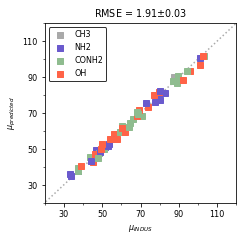

In [4]:
## PLOT PARITY
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_parity" )
plot_parity( y_indus, y_pred,
             xerr     = y_indus_err,
             yerr     = y_pred_err,
             title    = r"RMSE = {:.2f}$\pm${:.2f}".format( rmse, rmse_err ),
             xlabel   = r"$\mu_{INDUS}$",
             ylabel   = r"$\mu_{predicted}$",
             xticks   = [ 30, 110, 20 ],
             yticks   = [ 30, 110, 20 ],
             colors   = colors,
             legend   = [ [ "darkgrey", "slateblue", "darkseagreen", "tomato" ],
                          [ "CH3", "NH2", "CONH2", "OH" ] ],
             fig_path = fig_path, )

## PLOTTING FEATURE WEIGHTS


--- CREATING BAR PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_weights


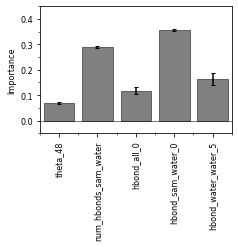

In [5]:
## CREATE PLACEHOLDERS
labels      = []
weights     = []
weights_err = []

## SELECT FEATURES (LOOP TO KEEP ORDER)
for ll in raw_data["sample1"].columns.values:
    if ll in weights_df.index.values:
        labels.append( ll )
        weights.append( weights_df[ll] )
        weights_err.append( weights_err_df[ll] )

## PLOT WEIGHTS
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_weights" )
plot_bar( [ np.arange( 0, len(weights), 1 ) ],
          [ weights ], 
          yerr     = [ weights_err ],
          xlabel   = labels,
          ylabel   = r"Importance",
          yticks   = [  0,  0.4,  0.1 ],
          colors   = [ "grey" ],
          fig_path = fig_path )

## OPTIMIZE HYPERPARAMETERS

In [6]:
## OPTIMAL HYPERPARAMETERS
n_trees      = 200    # number of trees (splits)
max_samples  = None   # max fraction samples to train a tree
max_features = 0.5    # max fraction of features at each split
max_depth    = None   # max tree depth
n_features   = 5      # number features

### CHECK TRAINING DATA SIZE

In [7]:
## MAX NUMBER
n_samples_max = 58

## CREATE DATA HOLDERS
train_sizes   = np.arange( 1, n_samples_max+2, 2 )
rmse_size     = []
rmse_size_err = []

## INITIALIZE RANDOM FOREST
rf_obj = RandomForestRegression( n_trees      = n_trees,
                                 max_samples  = None, # max_samples,
                                 max_features = max_features,
                                 max_depth    = max_depth,
                                 n_features   = n_features )

## LOOP THROUGH TRAINING SIZE
for ii in train_sizes:
    ## COMPUTE RANDOM FOREST
    rf_obj.compute( raw_data, n_samples = ii )
    
    ## STORE RESULTS
    rmse_size.append( rf_obj.rmse )
    rmse_size_err.append( rf_obj.rmse_err )

## CONVERT TO NUMPY ARRAYS
rmse_size     = np.array( rmse_size )
rmse_size_err = np.array( rmse_size_err )


--- CREATING LINE PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_training_size_cv


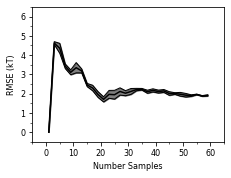

In [8]:
## PLOT LINE
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_training_size_cv" )
plot_line( [ train_sizes, ], 
           [ rmse_size, ],
           yerr        = [ rmse_size_err, ],
           xlabel      = r"Number Samples",
           ylabel      = r"RMSE (kT)",
           xticks      = [ 0, 60, 10 ],
           yticks      = [ 0, 6, 1 ],
           colors      = [ "black" ],
           line_labels = None,
           fig_path    = fig_path, )

### NUMBER OF TREES CROSS-VALIDATION

In [9]:
## MAX NUMBER OF TREES
n_trees_max = 201

## CREATE DATA HOLDERS
n_trees_array   = np.arange( 1, n_trees_max+10, 10 )
rmse_ntrees     = []
rmse_ntrees_err = []

## LOOP THROUGH ALPHAS
for nn in n_trees_array:
    ## INITIALIZE RANDOM FOREST
    rf_obj = RandomForestRegression( n_trees      = nn,
                                     max_samples  = max_samples,
                                     max_features = max_features,
                                     max_depth    = max_depth,
                                     n_features   = n_features )

    ## COMPUTE 5-FOLD CV USING LASSO
    rf_obj.compute( raw_data )

    ## STORE RESULTS
    rmse_ntrees.append( rf_obj.rmse )
    rmse_ntrees_err.append( rf_obj.rmse_err )

## CONVERT TO NUMPY ARRAYS
rmse_ntrees      = np.array( rmse_ntrees )
rmse_ntrees_err  = np.array( rmse_ntrees_err )


--- CREATING LINE PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_num_trees_cv


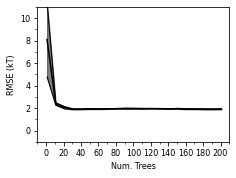

In [18]:
## PLOT LINE
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_num_trees_cv" )
plot_line( [ n_trees_array ], 
           [ rmse_ntrees, ],
           yerr        = [ rmse_ntrees_err, ],
           xlabel      = r"Num. Trees",
           ylabel      = r"RMSE (kT)",
           xticks      = [ 0, 200, 20 ],
           yticks      = [ 0, 10, 2 ],
           colors      = [ "black" ],
           line_labels = None,
           fig_path    = fig_path, )

### MAX FEATURES IN LEAF (SPLIT) CROSS-VALIDATION

In [11]:
## CREATE DATA HOLDERS
n_samples_leaf_array   = np.arange( 0.09, 1.09, 0.1 )
rmse_nsamples_leaf     = []
rmse_nsamples_leaf_err = []

## LOOP THROUGH ALPHAS
for nn in n_samples_leaf_array:
    ## INITIALIZE RANDOM FOREST
    rf_obj = RandomForestRegression( n_trees      = n_trees,
                                     max_samples  = max_samples,
                                     max_features = nn,
                                     max_depth    = max_depth,
                                     n_features   = n_features )

    ## COMPUTE 5-FOLD CV USING LASSO
    rf_obj.compute( raw_data )

    ## STORE RESULTS
    rmse_nsamples_leaf.append( rf_obj.rmse )
    rmse_nsamples_leaf_err.append( rf_obj.rmse_err )

## CONVERT TO NUMPY ARRAYS
rmse_nsamples_leaf     = np.array( rmse_nsamples_leaf )
rmse_nsamples_leaf_err = np.array( rmse_nsamples_leaf_err )


--- CREATING LINE PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_num_samples_leaf_cv


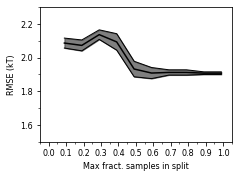

In [12]:
## PLOT LINE
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_num_samples_leaf_cv" )
plot_line( [ n_samples_leaf_array ], 
           [ rmse_nsamples_leaf, ],
           yerr        = [ rmse_nsamples_leaf_err, ],
           xlabel      = r"Max fract. samples in split",
           ylabel      = r"RMSE (kT)",
           xticks      = [ 0, 1, 0.1 ],
           yticks      = [ 1.6, 2.2, 0.2 ],
           colors      = [ "black" ],
           line_labels = None,
           fig_path    = fig_path, )

### MAX DEPTH FOR TREES CROSS-VALIDATION

In [13]:
## MAX NUMBER OF SAMPLES IN A SPLIT
n_depth_max = 20

## CREATE DATA HOLDERS
n_depths       = np.arange( 2, n_depth_max+2, 2 )
rmse_depth     = []
rmse_depth_err = []

## LOOP THROUGH ALPHAS
for nn in n_depths:
    ## INITIALIZE RANDOM FOREST
    rf_obj = RandomForestRegression( n_trees      = n_trees,
                                     max_samples  = max_samples,
                                     max_features = max_features,
                                     max_depth    = nn,
                                     n_features   = n_features )

    ## COMPUTE 5-FOLD CV USING LASSO
    rf_obj.compute( raw_data )

    ## STORE RESULTS
    rmse_depth.append( rf_obj.rmse )
    rmse_depth_err.append( rf_obj.rmse_err )

## CONVERT TO NUMPY ARRAYS
rmse_depth      = np.array( rmse_depth )
rmse_depth_err  = np.array( rmse_depth_err )


--- CREATING LINE PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_max_depth_tree_cv


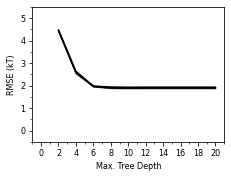

In [14]:
## PLOT LINE
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_max_depth_tree_cv" )
plot_line( [ n_depths, ], 
           [ rmse_depth, ],
           yerr        = [ rmse_depth_err, ],
           xlabel      = r"Max. Tree Depth",
           ylabel      = r"RMSE (kT)",
           xticks      = [ 0, 20, 2 ],
           yticks      = [ 0, 5, 1 ],
           colors      = [ "black" ],
           line_labels = None,
           fig_path    = fig_path, )

### MIN FEATURES TO KEEP CROSS-VALIDATION

In [15]:
## MAX NUMBER OF SAMPLES TO TRAIN EACH TREE
n_features_max = raw_data["sample1"].shape[1]

## CREATE DATA HOLDERS
n_features_array   = np.arange( 2, n_features_max+2, 2 )
rmse_nfeatures     = []
rmse_nfeatures_err = []

## LOOP THROUGH ALPHAS
for nn in n_features_array:
    ## INITIALIZE RANDOM FOREST
    rf_obj = RandomForestRegression( n_trees      = n_trees,
                                     max_samples  = max_samples,
                                     max_features = max_features,
                                     max_depth    = max_depth,
                                     n_features   = nn )

    ## COMPUTE 5-FOLD CV USING LASSO
    rf_obj.compute( raw_data )

    ## STORE RESULTS
    rmse_nfeatures.append( rf_obj.rmse )
    rmse_nfeatures_err.append( rf_obj.rmse_err )

## CONVERT TO NUMPY ARRAYS
rmse_nfeatures      = np.array( rmse_nfeatures )
rmse_nfeatures_err  = np.array( rmse_nfeatures_err )


--- CREATING LINE PLOT ---
FIGURE SAVED TO: /mnt/c/Users/bdallin/Box Sync/univ_of_wisc/manuscripts/chemically_heterogeneous_sams/figures/rf_n_features_cv


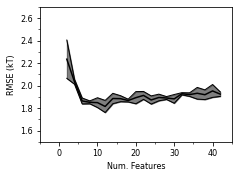

In [16]:
## PLOT LINE
fig_path = os.path.join( manuscript_dir, figure_dir, "rf_n_features_cv" )
plot_line( [ n_features_array, ], 
           [ rmse_nfeatures, ],
           yerr        = [ rmse_nfeatures_err, ],
           xlabel      = r"Num. Features",
           ylabel      = r"RMSE (kT)",
           xticks      = [ 0, 40, 10 ],
           yticks      = [ 1.6, 2.6, 0.2 ],
           colors      = [ "black" ],
           line_labels = None,
           fig_path    = fig_path, )